# YoLOお試し実行

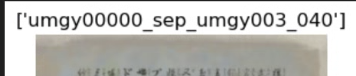

umgy00000_sep_umgy003_040

In [8]:
from ultralytics import YOLO

# YOLOv8の学習済みモデルをロード
model = YOLO('yolov8n.pt')  # 'n'はnanoモデルの意味。他にもs, m, l, xなどがあります。

# 画像を指定して推論を実行
# sourceには画像のパス、URL、動画ファイル、カメラID(0)などを指定できます。
# results = model('../../.image_data/100241706_00002_2.jpg')
results = model('https://ultralytics.com/images/bus.jpg')

# 結果の表示
for r in results:
    r.show() # 結果を画像で表示

# 結果をファイルに保存
# results = model('https://ultralytics.com/images/bus.jpg', save=True, project='my_results', name='bus_detection')

100%|██████████| 6.25M/6.25M [00:00<00:00, 11.0MB/s]


100%|██████████| 134k/134k [00:00<00:00, 13.3MB/s]

image 1/1 c:\Users\kotat\MyPrograms\MyKuzushiji\Craft_respect\test\Yolo_trial\bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 10.5ms
Speed: 7.7ms preprocess, 10.5ms inference, 20.3ms postprocess per image at shape (1, 3, 640, 480)


# YOLOを学習させる

## 学習データ・データローダーの用意

In [9]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.my_app.core.MyDataset.OldMyDataset_speed import PreTrainDataset_old
import torchvision.transforms as transforms
import multiprocessing as mp

transform = transforms.Compose([
    # transforms.Resizeze((128, 128)),
    transforms.ToTensor()
])
# --- Dataset ---
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']

train_dataset = dataset = PreTrainDataset_old(
    input_path='../../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    precompute_gt=True,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)

test_dataset = PreTrainDataset_old(
    input_path='../../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=True,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    precompute_gt=True,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)
# 最適化されたDataLoaderの作成
train_dl = PreTrainDataset_old.create_optimized_dataloader_for_old_dataset(
    train_dataset,
    batch_size=1,
    num_workers=min(mp.cpu_count(), 4)
)
test_dl = PreTrainDataset_old.create_optimized_dataloader_for_old_dataset(
    test_dataset,
    batch_size=1,
    num_workers=min(mp.cpu_count(), 4)
)

MemoryError: 

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
num_epochs = 10  # 学習エポック数
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for imgs, targets in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(model.device).float()
        targets = [t.to(model.device).float() for t in targets]  # list of [num_obj, 5]

        results = model(imgs, targets=targets, verbose=False)
        loss = results[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # 検証ループ（テストローダーが存在する前提）
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in test_dl:
            imgs = imgs.to(model.device).float()
            targets = [t.to(model.device).float() for t in targets]
            results = model(imgs, targets=targets, verbose=False)
            val_loss += results[0].item()
    avg_val_loss = val_loss / len(test_dl)
    val_losses.append(avg_val_loss)

    model.train()

    # チェックポイント保存
    ckpt_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), ckpt_path)

# 損失のプロット
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()
